# Pfizer Vaccine Tweets

This dataset is from [Kaggle]('https://www.kaggle.com/gpreda/pfizer-vaccine-tweets'), compiled by user Gabriel Preda. I will be clustering the tweets to find any common themes among them, determining the sentiment of each tweet to see how the general public has reacted to the Pfizer BioNTech vaccine, and finally analyzing how sentiment has changed over time.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import plotly.express as px
import plotly.graph_objs as go
from datetime import datetime as dt

#If the hub.load line throws an error, it can likely be fixed by deleting the 
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from umap import UMAP

import nltk
from textblob import TextBlob
from wordcloud import WordCloud

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# I use this function later to determine the most common word in each of cluster of tweets
def most_frequent(a_list): 
    return max(set(a_list), key = a_list.count)

In [3]:
tweets = pd.read_csv('vaccination_tweets.csv')
tweets.head()

id             user_name              user_location  \
0  1340539111971516416            Rachel Roh  La Crescenta-Montrose, CA   
1  1338158543359250433           Albert Fong          San Francisco, CA   
2  1337858199140118533              eli🇱🇹🇪🇺👌                   Your Bed   
3  1337855739918835717         Charles Adler     Vancouver, BC - Canada   
4  1337854064604966912  Citizen News Channel                        NaN   

                                    user_description         user_created  \
0  Aggregator of Asian American news; scanning di...  2009-04-08 17:52:46   
1  Marketing dude, tech geek, heavy metal & '80s ...  2009-09-21 15:27:30   
2                                     heil, hydra 🖐☺  2020-06-25 23:30:28   
3  Hosting "CharlesAdlerTonight" Global News Radi...  2008-09-10 11:28:53   
4  Citizen News Channel bringing you an alternati...  2020-04-23 17:58:42   

   user_followers  user_friends  user_favourites  user_verified  \
0             405          1692             3247          False   
1             834           666              178          False   
2              10            88              155          False   
3           49165          3933            21853           True   
4             152           580             1473          False   

                  date                                               text  \
0  2020-12-20 06:06:44  Same folks said daikon paste could treat a cyt...   
1  2020-12-13 16:27:13  While the world has been on the wrong side of ...   
2  2020-12-12 20:33:45  #coronavirus #SputnikV #AstraZeneca #PfizerBio...   
3  2020-12-12 20:23:59  Facts are immutable, Senator, even when you're...   
4  2020-12-12 20:17:19  Explain to me again why we need a vaccine @Bor...   

                                            hashtags               source  \
0                                 ['PfizerBioNTech']  Twitter for Android   
1                                                NaN      Twitter Web App   
2  ['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...  Twitter for Android   
3                                                NaN      Twitter Web App   
4     ['whereareallthesickpeople', 'PfizerBioNTech']   Twitter for iPhone   

   retweets  favorites  is_retweet  
0         0          0       False  
1         1          1       False  
2         0          0       False  
3       446       2129       False  
4         0          0       False

In [4]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3945 entries, 0 to 3944
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                3945 non-null   int64 
 1   user_name         3945 non-null   object
 2   user_location     3119 non-null   object
 3   user_description  3698 non-null   object
 4   user_created      3945 non-null   object
 5   user_followers    3945 non-null   int64 
 6   user_friends      3945 non-null   int64 
 7   user_favourites   3945 non-null   int64 
 8   user_verified     3945 non-null   bool  
 9   date              3945 non-null   object
 10  text              3945 non-null   object
 11  hashtags          2934 non-null   object
 12  source            3944 non-null   object
 13  retweets          3945 non-null   int64 
 14  favorites         3945 non-null   int64 
 15  is_retweet        3945 non-null   bool  
dtypes: bool(2), int64(6), object(8)
memory usage: 439.3+ KB


# Cleaning 

In [5]:
#Convert data column to datetime for use later
tweets['user_created'] = pd.to_datetime(tweets['user_created'])
tweets['date'] = pd.to_datetime(tweets['date'])

tweets['account_age'] = tweets['date'] - tweets['user_created']

In [6]:
#Remove whitespace, URLs, and numbers
tweets['text'] = tweets['text'].str.strip()

tweets['no_url'] = tweets['text'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
tweets["alpha_num"] = tweets["no_url"].str.replace("[^a-zA-Z ]", "", regex=True)

twitter_docs = list(tweets['alpha_num'])

In [7]:
def removeStopWords(stopWords, txt):
    newtxt = ' '.join([word for word in txt.split() if word not in stopWords])
    return newtxt


from nltk.corpus import stopwords
stops = stopwords.words("English")
#I remove these words since nearly every tweet contains them, making clusters meaningless 
stop_set = ['vaccine', 'vaccines', 'vaccination', 'vaccinated', 'pfizerbiontech', 'covid_vaccine',
            'covid19', 'pfizer', 'coronavirus', 'covidvaccine', 'covid', 'pfizercovidvaccine', 'get', 'got',
           'pfizervaccine', 'biontech', 'PfizerBioNTech', 'vaccinations', 'dose', 'first', 'b', 'c', 'd', 'e', 'f', 'g', 'h',
           'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'amp']
for word in stop_set:
    stops.append(word)

twitter_docs = [doc.lower() for doc in twitter_docs]
tweets_processed = [removeStopWords(stops,x) for x in twitter_docs]

In [8]:
#Convert to a numpy array
embeddings = embed(tweets_processed).numpy()

In [9]:
embedding_df = pd.DataFrame(embeddings)
embedding_df['tweet'] = tweets_processed

In [10]:
embedding_df.head()

0         1         2         3         4         5         6  \
0  0.003676  0.042086  0.000025  0.030364  0.002031  0.055607  0.087734   
1 -0.025650 -0.092020 -0.060369  0.023752 -0.076523  0.068336 -0.081134   
2  0.053071 -0.034817 -0.056102 -0.050035 -0.082008  0.037826 -0.028849   
3  0.005456 -0.032897 -0.069155 -0.012665  0.030124  0.055990 -0.034106   
4 -0.022313 -0.051816  0.053458  0.007297  0.077845  0.023940  0.034195   

          7         8         9  ...       503       504       505       506  \
0 -0.011573 -0.031769  0.088078  ...  0.052980 -0.022661  0.003750  0.037206   
1 -0.046448  0.080280  0.034739  ...  0.033505  0.005086  0.059610  0.024280   
2 -0.001703 -0.023368 -0.015179  ...  0.059053  0.021956 -0.022393  0.014465   
3 -0.023317  0.018719  0.014159  ...  0.062069  0.007733  0.028939  0.015990   
4 -0.001136 -0.005240  0.053218  ...  0.030622  0.063262 -0.001377  0.001388   

        507       508       509       510       511  \
0 -0.043189 -0.059432  0.038828 -0.039708  0.000414   
1 -0.024206 -0.037989 -0.029614 -0.058409  0.011761   
2  0.062120  0.020998 -0.046131  0.001560 -0.106796   
3 -0.053795  0.065114  0.033493 -0.034042  0.005548   
4 -0.035761  0.003327 -0.080122  0.010798 -0.018673   

                                               tweet  
0  folks said daikon paste could treat cytokine s...  
1  world wrong side history year hopefully bigges...  
2  sputnikv astrazeneca moderna russian created l...  
3  facts immutable senator even youre ethically s...  
4  explain need borisjohnson matthancock whereare...  

[5 rows x 513 columns]

# Dimension Reduction for Visualizations

Using UMAP and PCA, I will reduce the dimensions for visualization purposes only. The actual clustering will be done on the raw data.

In [11]:
dbscan_eps = 0.5
dbscan_min_samples = 20
k = 10

In [12]:
X = embedding_df.drop('tweet', axis = 1)

umap = UMAP(n_components = 2, n_neighbors = 10)
components_umap = umap.fit_transform(X)


embeddings_2d = pd.DataFrame(components_umap, columns=['x1', 'x2'])
embeddings_2d['tweet'] = tweets_processed

In [13]:
X = embedding_df.drop('tweet', axis =1)
pca = PCA(n_components = 2)
pca_components = pca.fit_transform(X)

embeddings_2d_pca = pd.DataFrame(pca_components, columns=['x1', 'x2'])
embeddings_2d_pca['tweet'] = tweets_processed


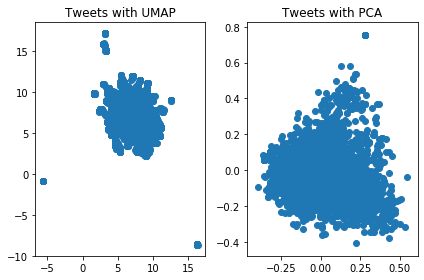

In [14]:
plt.subplot(1, 2, 1)
plt.scatter(data = embeddings_2d, x = 'x1', y = 'x2')
plt.title('Tweets with UMAP')


plt.subplot(1, 2, 2)
plt.scatter(data = embeddings_2d_pca, x = 'x1', y = 'x2')
plt.title('Tweets with PCA')

plt.tight_layout()
plt.show()

# DBSCAN

In [15]:
X = embedding_df.drop('tweet', axis = 1)
dbscan = DBSCAN(eps = dbscan_eps, min_samples = dbscan_min_samples, metric ='cosine')
dbscan.fit(X)

DBSCAN(metric='cosine', min_samples=20)

In [16]:
embeddings_2d['cluster'] = dbscan.labels_
embeddings_2d['cluster'].value_counts()

-1    3097
 0     462
 7      84
 4      68
 3      58
 1      58
 2      50
 5      28
 8      20
 6      20
Name: cluster, dtype: int64

In [17]:
embeddings_2d['tweet'] = tweets_processed
embeddings_2d_pca['tweet'] = tweets_processed

In [18]:
dbscan_umap = embeddings_2d[embeddings_2d['cluster'] != -1]
dbscan_pca = embeddings_2d_pca
dbscan_pca['cluster'] = dbscan.labels_
dbscan_pca = dbscan_pca[dbscan_pca['cluster'] != -1]

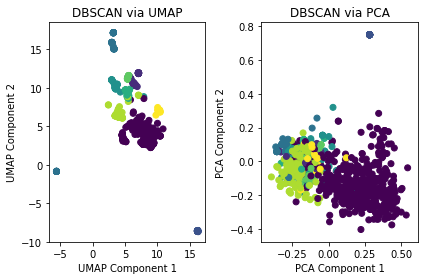

In [19]:
plt.subplot(1, 2, 1)
plt.scatter(data = dbscan_umap, x = 'x1', y = 'x2', c = 'cluster')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('DBSCAN via UMAP')

plt.subplot(1, 2, 2)
plt.scatter(data = dbscan_pca, x = 'x1', y = 'x2', c = 'cluster')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('DBSCAN via PCA')

plt.tight_layout()
plt.show()

In [20]:
dbscan_full = embedding_df.copy()
dbscan_full['cluster'] = dbscan.labels_
dbscan_full = dbscan_full[dbscan_full['tweet'] != '']

In [21]:
cluster_map = {}
for cluster in dbscan_full['cluster'].unique():
    cluster_text = dbscan_full[dbscan_full['cluster'] == cluster]['tweet']
    test_tokens = [nltk.word_tokenize(tweet) for tweet in cluster_text]
    test_flat =[token for sublist in test_tokens for token in sublist]
    cluster_map[cluster] = most_frequent(test_flat)

In [22]:
dbscan_full['label'] = dbscan_full['cluster'].map(cluster_map)
dbscan_full['cluster'].unique()

array([-1,  3,  1,  0,  7,  8,  4,  5,  6], dtype=int64)

# KMeans

In [23]:
X = embedding_df.drop('tweet', axis = 1)

kmeans = KMeans(n_clusters = len(dbscan_full['cluster'].unique()))
kmeans.fit(X)

KMeans(n_clusters=9)

In [24]:
embeddings_2d['cluster'] = kmeans.labels_
print(embeddings_2d['cluster'].value_counts())

kmeans_clusters = embeddings_2d[embeddings_2d['cluster'] != -1]
kmeans_pca = embeddings_2d_pca.copy()
kmeans_pca['cluster'] = kmeans.labels_

5    803
6    651
3    591
8    528
2    462
4    377
1    260
0    223
7     50
Name: cluster, dtype: int64


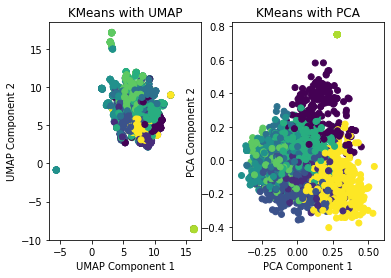

In [25]:
plt.subplot(1, 2, 1)
plt.scatter(data = kmeans_clusters, x = 'x1', y = 'x2', c = 'cluster')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('KMeans with UMAP')

plt.subplot(1, 2, 2)
plt.scatter(data = kmeans_pca, x = 'x1', y = 'x2', c = 'cluster')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('KMeans with PCA')
plt.show()

In [26]:
cluster_map = {}
for cluster in kmeans_clusters['cluster'].unique():
    cluster_text = kmeans_clusters[kmeans_clusters['cluster'] == cluster]['tweet']
    if not cluster_text.any() == '':
        test_tokens = [nltk.word_tokenize(tweet) for tweet in cluster_text]
        test_flat =[token for sublist in test_tokens for token in sublist]
        cluster_map[cluster] = most_frequent(test_flat)

In [27]:
kmeans_clusters['label'] = kmeans_clusters['cluster'].map(cluster_map)

In [28]:
kmeans_clusters['label'].value_counts()

moderna    803
doses      651
mrna       591
today      528
nurse      462
dubai      377
side       260
second     223
Name: label, dtype: int64

In [29]:
dbscan_full['label'].value_counts()

today        3559
norway         84
dubai          68
ban            58
use            58
million        28
emergency      20
whowpro        20
Name: label, dtype: int64

Both KMeans and DBSCAN identify a few common phrases like "first" and "dose." They both also picked out some locations like "Dubai" and "Norway." Sentiment about the vaccine may vary based on location.

# Sentiment Analysis

In [30]:
tokens = [nltk.word_tokenize(tweet) for tweet in tweets_processed]
flat_tokens = [token for sublist in tokens for token in sublist]

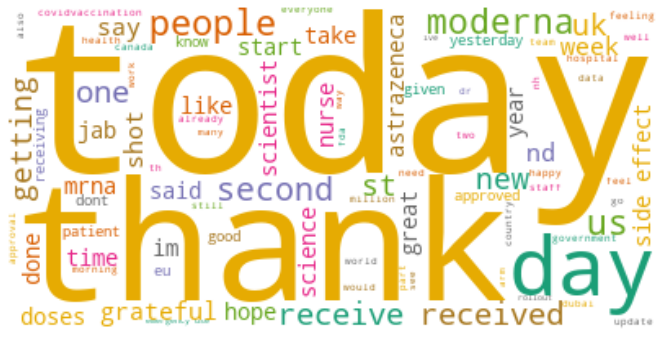

In [31]:
wc = WordCloud(stopwords=stops, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)
plt.rcParams['figure.figsize'] = [16, 6]
wc.generate(" ".join(list(flat_tokens)))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")    
plt.show()

From the word cloud, it appears that most of these tweets are about being thankful for recieving the first dose of the vaccine on the day the user tweeted.

In [32]:
unique_tokens = []
for token in flat_tokens:
    if token not in unique_tokens:
        unique_tokens.append(token)
        
        
unique_tokens.sort()

In [33]:
#creates a vector for each unique token in the tweets
vectorizer = CountVectorizer(analyzer = "word", 
                             preprocessor = None, 
                             stop_words =  'english', 
                             max_features = len(unique_tokens), ngram_range=(1,5))
data_features = vectorizer.fit_transform(tweets_processed)
tfidf_transformer = TfidfTransformer()
data_features_tfidf = tfidf_transformer.fit_transform(data_features)
data_mat = data_features_tfidf.toarray()
data_mat_df = pd.DataFrame(data_mat)
data_mat_df['tweet'] = tweets_processed

In [34]:
sparse_df = pd.DataFrame.sparse.from_spmatrix(data_features)
sparse_df['tweet'] = tweets_processed
sparse_df.shape

(3945, 8337)

There is one row for each tweet and one column for each unique word in the corpus

From TextBlob [docs](https://textblob.readthedocs.io/en/dev/quickstart.html):

"The sentiment property returns a namedtuple of the form Sentiment(polarity, subjectivity). The polarity score is a float within the range [-1.0, 1.0]. The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective."

For this project, I will only be working with polarity.

In [35]:
#Create polarity function and subjectivity function
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity
pol_list = [pol(x) for x in tweets_processed]
sub_list = [sub(x) for x in tweets_processed]

In [36]:
#Assign labels for polarity
sentiment_list = []
for i in range(len(pol_list)):
    if pol_list[i] > 0:
        sentiment_list.append('Positive')
    elif pol_list[i] < 0:
        sentiment_list.append('Negative')
    else:
        sentiment_list.append('Neutral')

In [37]:
sparse_df['sentiment'] = sentiment_list
sparse_df.head(2)

0  1  2  3  4  5  6  7  8  9  ...  8328  8329  8330  8331  8332  8333  \
0  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
1  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   

   8334  8335                                              tweet  sentiment  
0     0     0  folks said daikon paste could treat cytokine s...    Neutral  
1     0     0  world wrong side history year hopefully bigges...   Negative  

[2 rows x 8338 columns]

In [38]:
sparse_df['sentiment'].value_counts()

Neutral     2238
Positive    1298
Negative     409
Name: sentiment, dtype: int64

In [39]:
(sparse_df['sentiment'].value_counts())/len(sparse_df)

Neutral     0.567300
Positive    0.329024
Negative    0.103676
Name: sentiment, dtype: float64

In [40]:
for cluster in sparse_df['sentiment'].unique():
    cluster_text = sparse_df[sparse_df['sentiment'] == cluster]['tweet']
    test_tokens = [nltk.word_tokenize(tweet) for tweet in cluster_text]
    test_flat =[token for sublist in test_tokens for token in sublist]
    print(f'Most frequent word in {cluster}: {most_frequent(test_flat)}')

Most frequent word in Neutral: today
Most frequent word in Negative: people
Most frequent word in Positive: new


In [41]:
positive = sparse_df[sparse_df['sentiment'] == 'Positive']
negative = sparse_df[sparse_df['sentiment'] == 'Negative']
neutral = sparse_df[sparse_df['sentiment'] == 'Neutral']

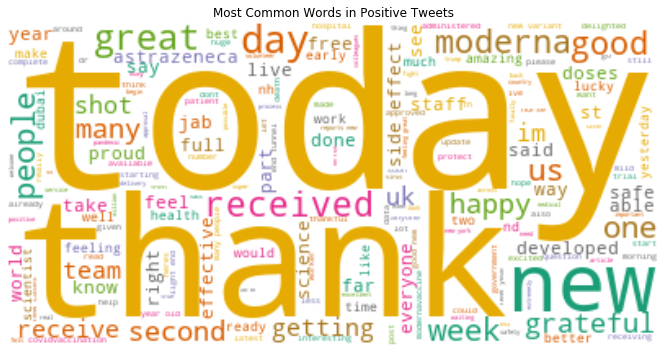

In [42]:
pos_tokens = [nltk.word_tokenize(tweet) for tweet in positive['tweet']]
pos_flat_tokens = [token for sublist in pos_tokens for token in sublist]

wc = WordCloud(stopwords=stops, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)
plt.rcParams['figure.figsize'] = [16, 6]
wc.generate(" ".join(list(pos_flat_tokens)))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Positive Tweets")
plt.show()

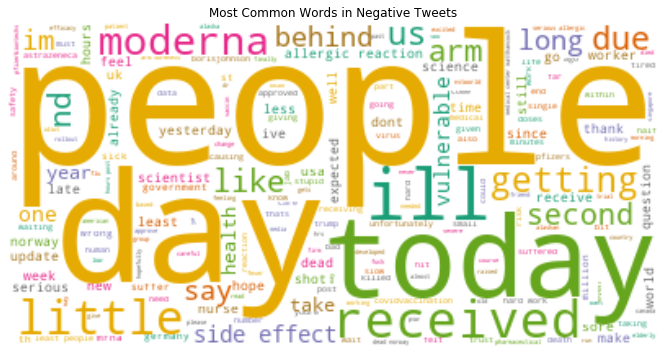

In [43]:
neg_tokens = [nltk.word_tokenize(tweet) for tweet in negative['tweet']]
neg_flat_tokens = [token for sublist in neg_tokens for token in sublist]

wc = WordCloud(stopwords=(stops), background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)
plt.rcParams['figure.figsize'] = [16, 6]
wc.generate(" ".join(list(neg_flat_tokens)))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Negative Tweets")
plt.show()

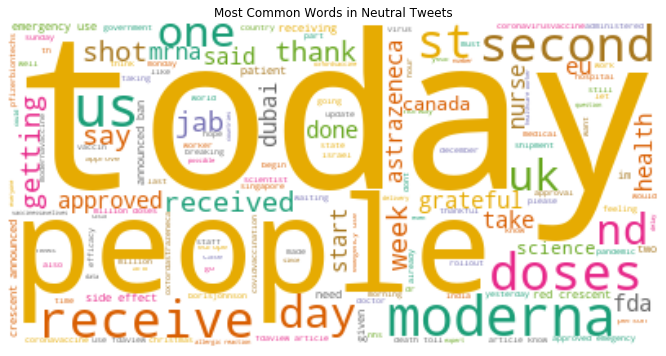

In [44]:
neu_tokens = [nltk.word_tokenize(tweet) for tweet in neutral['tweet']]
neu_flat_tokens = [token for sublist in neu_tokens for token in sublist]

wc = WordCloud(stopwords=stops, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)
plt.rcParams['figure.figsize'] = [16, 6]
wc.generate(" ".join(list(neu_flat_tokens)))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Neutral Tweets")
plt.show()

# Classifying Sentiment

In [45]:
X = sparse_df.drop(columns =['tweet', 'sentiment'])
y = sparse_df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 21)

## RandomForest

In [46]:
rf_model_0 = RandomForestClassifier()
rf_model_0.fit(X_train, y_train)

RandomForestClassifier()

In [47]:
y_pred = rf_model_0.predict(X_test)

In [48]:
pd.DataFrame(confusion_matrix(y_test, y_pred), columns =['Pred Neg', 'Pred Neu', 'Pred Pos'], index = ['True Neg', 'True Neu', 'True Pos'])

Pred Neg  Pred Neu  Pred Pos
True Neg        36        36        10
True Neu         2       440         5
True Pos         5        48       207

In [49]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Negative       0.84      0.44      0.58        82
     Neutral       0.84      0.98      0.91       447
    Positive       0.93      0.80      0.86       260

    accuracy                           0.87       789
   macro avg       0.87      0.74      0.78       789
weighted avg       0.87      0.87      0.86       789



This model performs fairly well, but I'll experient with hyperparams just to see if it can get even better.

In [50]:
rf_model_1 = RandomForestClassifier(n_estimators = 500, criterion = 'gini')
rf_model_1.fit(X_train, y_train)
y_pred = rf_model_1.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_pred), columns =['Pred Neg', 'Pred Neu', 'Pred Pos'], index = ['True Neg', 'True Neu', 'True Pos'])

Pred Neg  Pred Neu  Pred Pos
True Neg        37        36         9
True Neu         2       440         5
True Pos         5        51       204

In [51]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Negative       0.84      0.45      0.59        82
     Neutral       0.83      0.98      0.90       447
    Positive       0.94      0.78      0.85       260

    accuracy                           0.86       789
   macro avg       0.87      0.74      0.78       789
weighted avg       0.87      0.86      0.85       789



The first model performs slightly better. It is best at predicting when the tweet is neutral, but has trouble distinguishing negative sentiment. This make sense as neutral and positive tweets greatly outnumber the negative ones. More data with less class imbalance could fix this issue.

## KNeighborsClassifier

In [52]:
knn_0 = KNeighborsClassifier()
knn_0.fit(X_train, y_train)

KNeighborsClassifier()

In [53]:
y_pred_0 = knn_0.predict(X_test)

In [54]:
pd.DataFrame(confusion_matrix(y_test, y_pred_0), columns =['Pred Neg', 'Pred Neu', 'Pred Pos'], index = ['True Neg', 'True Neu', 'True Pos'])

Pred Neg  Pred Neu  Pred Pos
True Neg         0        82         0
True Neu         1       445         1
True Pos         0       245        15

In [55]:
print(classification_report(y_test, y_pred_0))

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        82
     Neutral       0.58      1.00      0.73       447
    Positive       0.94      0.06      0.11       260

    accuracy                           0.58       789
   macro avg       0.50      0.35      0.28       789
weighted avg       0.64      0.58      0.45       789



This model is super underfit and only predicts the majority class (neutral), so I'll try adjusting the hyperparameters.

In [56]:
knn_1 = KNeighborsClassifier(n_neighbors = 2, p=2)
knn_1.fit(X_train, y_train)
y_pred_1 = knn_1.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_pred_1), columns =['Pred Neg', 'Pred Neu', 'Pred Pos'], index = ['True Neg', 'True Neu', 'True Pos'])

Pred Neg  Pred Neu  Pred Pos
True Neg         9        72         1
True Neu         8       438         1
True Pos         8       232        20

In [57]:
print(classification_report(y_test, y_pred_1))

              precision    recall  f1-score   support

    Negative       0.36      0.11      0.17        82
     Neutral       0.59      0.98      0.74       447
    Positive       0.91      0.08      0.14       260

    accuracy                           0.59       789
   macro avg       0.62      0.39      0.35       789
weighted avg       0.67      0.59      0.48       789



This model has an F1-score barely higher than the default model, so I think KNeighbors is not the best model for this project.

# Sentiment Over Time

In [58]:
tweets['sentiment'] = sentiment_list

In [59]:
tweets['date'] = pd.to_datetime(tweets['date'])
for i in range(len(tweets['date'])):
    tweets['date'][i] = dt.strftime(tweets['date'][i], '%m/%d/%Y')
    
tweets['date'] = pd.to_datetime(tweets['date'])

C:\Users\rhais\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\rhais\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [60]:
sent_by_date = tweets[['date', 'sentiment']]
sent_by_date['count'] = [1 for i in range(len(tweets))]

C:\Users\rhais\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [61]:
df = pd.pivot_table(sent_by_date, values = 'count', index=['date'], columns = 'sentiment', aggfunc=np.sum)
fig = go.Figure()
for col in df.columns:
    fig.add_trace(go.Scatter(x=df.index, y=df[col].values,
                             name = col,
                             mode = 'markers+lines',
                             line=dict(shape='linear'),
                             connectgaps=True
                             ))
                  
fig.update_layout(title ='Opinion of Tweets on Pfizer COVID-19 Vaccine')
fig.update_xaxes(title = 'Date')
fig.update_yaxes(title = 'Number of Tweets')


The trends of each type of tweet generally follow the same trend. There is a sharp decrease in all types of tweets on December 25th. Interestingly, the number of total tweets peaks on January 9th, the same day as the Capitol Riots. The sharp decline in the number of tweets approaching January 17th may be due to a data collection error. If the data were collected today, it is possible that this decrease would not be present.

In [62]:
tweets['cluster'] = dbscan_full['cluster']
tweets['label'] = dbscan_full['label']
tweets['pol'] = pol_list

In [63]:
#Find the average age of accounts per sentiment group
tweets_age = tweets[['account_age', 'sentiment', 'text', 'user_verified', 'cluster', 'label']]
tweets_age['pol'] = pol_list
tweets_age = tweets_age[tweets_age['cluster'] != -1.0]
tweets_age['user_verified'] = tweets_age['user_verified'].astype(int)

C:\Users\rhais\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [64]:
grouped = tweets_age.groupby('sentiment')
mean = grouped.apply(lambda x: np.mean(x))
mean[['account_age']]

account_age
sentiment                             
Negative  2121 days 22:23:54.950617280
Neutral   2193 days 06:03:17.941176480
Positive  2480 days 19:58:02.821011680

In [65]:
grouped['account_age'].min()

sentiment
Negative   5 days 05:54:32
Neutral    0 days 00:05:42
Positive   0 days 07:24:04
Name: account_age, dtype: timedelta64[ns]

The Negative tweets have the youngest average account age of 5.75 years. Neutral tweets come from accounts with an average age of 6.15 years, and Positive tweets come from accounts with an average age of 6.96 years. However, the youngest account in each group do not follow this pattern. The Neutral group had the youngest account of only 5 minutes. 

In [66]:
#Find the overall sentiment per cluster given by DBSCAN
tweets_age.dropna(inplace=True)
for cluster in tweets_age['cluster'].unique():
    group = tweets_age[tweets_age['cluster'] == cluster]
    label = group['label'].values[0]
    avg_pol = group['pol'].mean()
    print(f"Cluster: {cluster} - {label}")
    if avg_pol > 0:
        print('Average sentiment: Positive')
    elif avg_pol < 0:
            print('Average sentiment: Negative')
    else:
        print('Average sentiment: Neutral')
    print('---------------------------------------')

Cluster: 3.0 - ban
Average sentiment: Positive
---------------------------------------
Cluster: 1.0 - use
Average sentiment: Positive
---------------------------------------
Cluster: 0.0 - today
Average sentiment: Positive
---------------------------------------
Cluster: 7.0 - norway
Average sentiment: Negative
---------------------------------------
Cluster: 8.0 - whowpro
Average sentiment: Positive
---------------------------------------
Cluster: 4.0 - dubai
Average sentiment: Positive
---------------------------------------
Cluster: 5.0 - million
Average sentiment: Positive
---------------------------------------
Cluster: 6.0 - emergency
Average sentiment: Positive
---------------------------------------


DBSCAN clustered the tweets in such a way that most clusters have an overall positive sentiment even though the majority of tweets are neutral. This also tells us that the tweets mentioning the Moderna vaccine are largely positive as well.

# Verified vs Non-Verified Users

In [67]:
grouped = tweets_age.groupby('sentiment')
mean = grouped.apply(lambda x: np.mean(x))
mean[['user_verified']]

user_verified
sentiment               
Negative        0.111111
Neutral         0.132609
Positive        0.132296

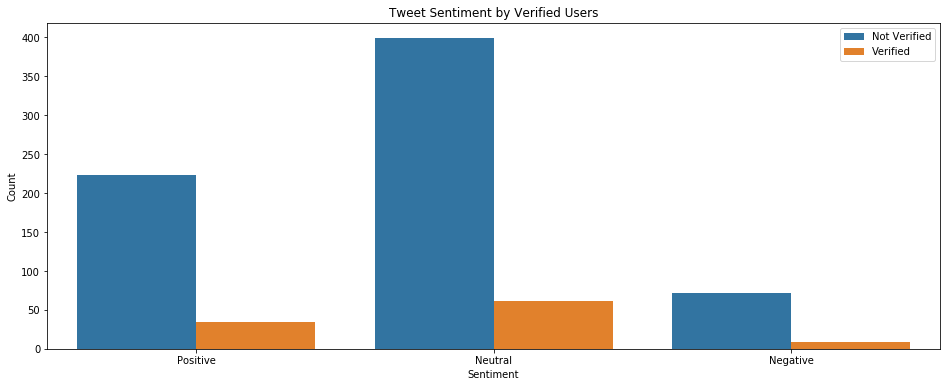

In [68]:
sns.countplot(data = tweets_age, x = 'sentiment', hue='user_verified')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Tweet Sentiment by Verified Users')
plt.legend(['Not Verified', 'Verified'])
plt.show()

The majority of verified users tweet positive tweets about the Pfizer vaccine, even though only about 10% of tweets in each category come from verified users. Further work could include statistical tests to determine whether a significant difference between verified and non-verified users exist.

# Conclusion

The majority of these tweets are neutral, and are likely news sources simply reporting updates on the vaccine. Whether or not the user is verified doesn't seem to matter. Pfizer and other companies with their own vaccines may find this information useful to address public concerns, as the quickest way to end the pandemic may well be to vaccinate everyone. 

# Further Work

To gauge the accuracy of TextBlob's sentiment function, it would be necessary to manually label each tweet as positive, negative, or neutral. Additionally, other classifiers such as SVC should be tried to get the best accuracy.

It would also be interesting to work with the subjectivity aspect of the sentiment function to see if this affects how the tweets are labeled.

Further work could also include looking for seasonality in the sentiment of tweets as more data is collected. Additionally, if more tweets are compiled, deep learning classification models could be built, possibly leading to even better accuracy.